<font size="5.5"><u><i>Prepare Waveforms</i></u></font>

Preparation of multiple phenomenological gravitational waves emitted by core-collapse supernovae</font>
<br/>
Author: Manuel David Morales

## 1. Library imports

In [1]:
# Data analysis
import numpy as np 
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Files/folders management
import os, glob, sys, re

# Scientific computing
from scipy import signal

# Garbage collector
import gc

# Object serialization
import pickle

# Show time execution
import time as tm

# Toolbox functions
from Toolbox import extract_WFinfo, resample_gw, SNR, SNR_PyCBC, WaveletTF_transform, Morlet_wavelet

/home/manuel/.programs/anaconda3/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


### 1.1 Function to compute execution time

In [2]:
def execution_time(ini_time, end_time, exe_time_t):
    
    exe_time = end_time - ini_time
    exe_time_tot = exe_time_t + exe_time
    
    print("")
    print("===========================================================================")
    print(f"Execution time current cell (seconds): {exe_time}")
    print(f"Total execution time (seconds): {exe_time_tot}")

    return exe_time_tot

In [3]:
exe_time_t = 0.0

## 2. Input parameters

In [4]:
ini_time = tm.time()

# Rescaling factor for all waveforms
# -----------------------------------------------------------
Resc_factor =  3.0e-22

# Options
# -----------
# High SNR values: 8.0e-22 (for L1, H1), 4.0e-21 (for V1)
# Low SNR values: 5.0e-22 (for L1, H1), 

# -----------------------------------------------------------
# Remark: This option was tuned by monitorying
# SNR distributions on Populations_Explorer script

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.00020956993103027344
Total execution time (seconds): 0.00020956993103027344


## 3. Read files

In [5]:
ini_time = tm.time()

# ------> Specify folders/files

wf_dir = "/home/manuel/Research Projects/GW Data analysis/GitHub/datagen-sngw-phen/Waveforms_orig/"

# Class 1 waveforms
wf_dir_c1 = wf_dir + "/Phen/class1/"
wf_files_c1 = sorted(glob.glob(wf_dir_c1 + '*.csv'))
print("No. of class 1 waveforms:", len(wf_files_c1))
#display(wf_files_c1)

# Class 2 waveforms
wf_dir_c2 = wf_dir + "Phen/class2/"
wf_files_c2 = sorted(glob.glob(wf_dir_c2 + '*.csv'))
print("No. of class 2 waveforms:", len(wf_files_c2))
#display(wf_files_c2)

# Class 3 waveforms
wf_dir_c3 = wf_dir + "Phen/class3/"
wf_files_c3 = sorted(glob.glob(wf_dir_c3 + '*.csv'))
print("No. of class 3 waveforms:", len(wf_files_c3))
#display(wf_files_c3)

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

No. of class 1 waveforms: 200
No. of class 2 waveforms: 200
No. of class 3 waveforms: 200

Execution time current cell (seconds): 0.003093242645263672
Total execution time (seconds): 0.0033028125762939453


In [6]:
ini_time = tm.time()

# ------> Read all waveform files

# Sort filenames per waveform class
wf_files = [wf_files_c1, wf_files_c2, wf_files_c3]

# Initialize dictionary for waveforms strain
wfs_o = {}

# Initialize dictionary for waveforms log data
waveforms_log = {}

# Initialize class count
class_count = 1

for class_files in wf_files:
    
    print("Reading waveforms of class", class_count)
    wfs_c_o = []
    wfslog_c = []
    
    # Read waveform files
    for csv in class_files:
    
        # Read waveform
        df = pd.read_csv(csv, usecols=['H'])
        strain = df['H'].to_numpy()
        wfs_c_o.append(strain)
    
        # Extract log data
        slope, f0, f1 = extract_WFinfo(csv)
        wfslog_c.append([slope, f0, f1])

        #print("File read:", csv)
        
    wfs_o["class " + str(class_count)] = wfs_c_o
    waveforms_log["class " + str(class_count)] = wfslog_c
    
    class_count += 1

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

Reading waveforms of class 1
Reading waveforms of class 2
Reading waveforms of class 3

Execution time current cell (seconds): 3.385706663131714
Total execution time (seconds): 3.389009475708008


In [7]:
# Checks
print("Keys of wfs_o dictionary: ", wfs_o.keys())
print("Keys of waveforms_log dictionary: ", waveforms_log.keys())

Keys of wfs_o dictionary:  dict_keys(['class 1', 'class 2', 'class 3'])
Keys of waveforms_log dictionary:  dict_keys(['class 1', 'class 2', 'class 3'])


## 4. Resampling/Rescaling

In [8]:
ini_time = tm.time()

# ------> Apply resampling to all waveforms

# Original sampling freq (Hz) and sampling time (seconds) of waveforms
fs = 16384
ts = 1 / fs

# Sort waveforms per class
wfs_ini = [wfs_o["class 1"], wfs_o["class 2"], wfs_o["class 3"]]

# Initialize dictionary for waveforms strain
waveforms = {}

# Initialize class count
class_count = 1

for wf in wfs_ini:
    
    print("Resampling waveforms of class", class_count)
    
    # Initialize list for single-class waveforms
    wfs_c = []
    
    # Initialize waveform count
    wf_count = 0
    
    for strain_o in wf:
        #print("Resampling waveform ", wf_count)
        #print(strain)
        t_o = []
        
        # Generate time array
        for i in range(len(strain_o)):
            t_o.append(i*ts)
        time_o = np.array(t_o)
    
        # -------------------
        # Resample waveform
        # -------------------
        fs_after = 4096
        time, strain = resample_gw(time_o, strain_o, fs_after)
        
        # ----------------------------------------
        # Rescale waveform strain by Resc_factor
        # ----------------------------------------
        strain = strain*Resc_factor
    
        # Save waveform into wfs_c list
        wf_block = np.transpose( np.vstack([time, strain]) )
        wfs_c.append(wf_block)
        
        # Compute waveform duration
        duration = time[-1] - time[0]
        
        # Convert duration value to string
        dur = f'{duration:.12f}'
        
        # Append waveform duration to waveforms_log list
        waveforms_log["class " + str(class_count)][wf_count].append(dur)
               
        wf_count += 1
        
    # Generate dicionary for all single-class waveforms
    waveforms["class " + str(class_count)] = wfs_c
    
    class_count += 1

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

Resampling waveforms of class 1
Resampling waveforms of class 2
Resampling waveforms of class 3

Execution time current cell (seconds): 2.402636766433716
Total execution time (seconds): 5.791646242141724


## 5. Sanity checks

In [9]:
#%%script false --no-raise-error # WARNING: DEACTIVATED CELL

# ------> Check dictionaries

print("Keys of waveforms dictionary: ", waveforms.keys())
print("Keys of waveforms_log dictionary: ", waveforms_log.keys())

# Remark: How to access waveforms and log data
# waveforms["class c"][n]  ---> to extract n-th waveform of class c
# waveforms_log["class c"][n]  ---> to extract log data of n-th waveform of class c
print("")
print("A waveform strain:", waveforms["class 2"][123]) # 123-th waveform of class 2
print("")
print("Its log information:", waveforms_log["class 2"][123]) # its log data

Keys of waveforms dictionary:  dict_keys(['class 1', 'class 2', 'class 3'])
Keys of waveforms_log dictionary:  dict_keys(['class 1', 'class 2', 'class 3'])

A waveform strain: [[ 0.00000000e+000  1.27593124e-120]
 [ 2.44140625e-004 -3.22222672e-106]
 [ 4.88281250e-004  7.00415465e-104]
 ...
 [ 8.38378906e-001 -4.92573455e-023]
 [ 8.38623047e-001  4.33308804e-023]
 [ 8.38867188e-001 -2.14651160e-023]]

Its log information: ['1493', '111.26', '1758.54', '0.838867187500']


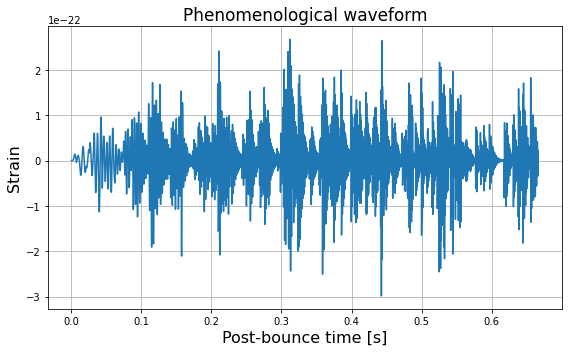


---------------------------------------------------------------------------
Slope=1031 | f0=116.08Hz | f1=1423.62Hz | Duration=0.666503906250s
---------------------------------------------------------------------------



<Figure size 432x288 with 0 Axes>

In [10]:
#%%script false --no-raise-error # WARNING: DEACTIVATED CELL

# ------> Plot a waveform

# Set waveform class and number
label = "3"
num_wf = 23

# Initialize lists for time and strain
time = []
strain = []

# Fill lists
for i in range(len(waveforms["class " + label][num_wf])):
    time.append(waveforms["class " + label][num_wf][i][0])
    strain.append(waveforms["class " + label][num_wf][i][1])
    
# Extract log information
slope = waveforms_log["class " + label][num_wf][0]
f0 = waveforms_log["class " + label][num_wf][1]
f1 = waveforms_log["class " + label][num_wf][2]
dur = waveforms_log["class " + label][num_wf][3]

# Plot waveform
plt.figure(1, figsize=(8,5))
plt.plot(time, strain)
plt.title("Phenomenological waveform", fontsize=17)
plt.xlabel('Post-bounce time [s]', fontsize=16)
plt.ylabel('Strain', fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()
plt.figure(1).clear()
gc.collect()
print("")
print("---------------------------------------------------------------------------")
print("Slope=" + slope + " | f0=" + f0 + "Hz | f1=" + f1 + "Hz | Duration=" + dur + "s")
print("---------------------------------------------------------------------------")
print("")

## 5. Save modified waveforms

In [11]:
ini_time = tm.time()

if not os.path.exists('../Waveforms_mod/Phen'): 
    os.makedirs('../Waveforms_mod/Phen')

# Save waveforms dictionary
with open('../Waveforms_mod/Phen/waveforms.pkl', 'wb') as fp:
    pickle.dump(waveforms, fp)
    print('waveforms dictionary saved successfully')
    
# Save waveforms_log dictionary
with open('../Waveforms_mod/Phen/waveforms_log.pkl', 'wb') as fp:
    pickle.dump(waveforms_log, fp)
    print('waveform_log dictionary saved successfully')
    
end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

waveforms dictionary saved successfully
waveform_log dictionary saved successfully

Execution time current cell (seconds): 0.47414302825927734
Total execution time (seconds): 6.265789270401001
